# Analyse des outputs de la BAN

## Imports

In [2]:
# Packages

import pandas as pd
import os
from geopy.distance import geodesic
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

os. getcwd()

'/home/onyxia/work/adresses-reu/travail_post_normalisation'

In [3]:
# Import des données renvoyées

# mc cp s3/projet-adresses-reu/data/sorties_BAN_20230203.parquet sorties_BAN.parquet

df = pd.read_parquet('/home/onyxia/work/adresses-reu/sorties_BAN.parquet')
df.head()

,id_adresse,geo_adresse,code_commune_ref,reconstitution_code_commune,commune_identique,id,api_line,geo_type,geo_score,longitude,latitude,id_brut_bv
0,41725,16 Rue des Oeillets 26600 Pont-de-l'Isère,26250,1,1,26250_0150_00016,BANG,housenumber,0.95,4.864017,45.004540,26250_2
1,72025,80 Chemin du Clos-vert 26190 Saint-Jean-en-Royans,26307,1,1,26307_0051_00080,BANG,housenumber,0.86,5.290095,45.009981,26307_1
2,11,220 Chemin du Vieux Menglon 26410 Menglon,26178,1,1,26178_0024_00220,BANG,housenumber,0.94,5.462369,44.665238,26178_1
3,30244,13 Rue Edgar de Vernejoul 26110 Nyons,26220,1,1,26220_0270_00013,BANG,housenumber,0.89,5.133026,44.359054,26220_4
4,14669,13 Rue des Muguets 26200 Montélimar,26198,1,1,26198_1576_00013,BANG,housenumber,0.97,4.735488,44.552760,26198_12


## Quelques vérifications et statistiques

### Dédoublonnage

In [4]:
len(df)

19370409

In [5]:
df_dedoublonnee = df.drop_duplicates(subset = ['id', 'geo_adresse', 'id_brut_bv'])
len(df_dedoublonnee)

16073868

### Nombre d'adresses par département

In [6]:
df_dedoublonnee['departement'] = df_dedoublonnee['code_commune_ref'].apply(lambda x : x[:2])
nb_adresses_par_departement = df_dedoublonnee.groupby('departement').size()
nb_adresses_par_departement.head(10)

/tmp/ipykernel_12019/3212230064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedoublonnee['departement'] = df_dedoublonnee['code_commune_ref'].apply(lambda x : x[:2])


departement
01    169972
02    167915
03    109075
04     41118
05     30883
06    120869
07    106208
08     84944
09     46492
10     90982
dtype: int64

### Scores

In [7]:
# df_dedoublonnee['geo_score'] = df_dedoublonnee.geo_score.round(2)
summary_scores = df_dedoublonnee.groupby('geo_type').geo_score.describe()
summary_scores

,count,mean,std,min,25%,50%,75%,max
geo_type,,,,,,,,
housenumber,15271659.0,0.930236,0.071466,0.30,0.94,0.95,0.960,0.99
interpolation,99051.0,0.910100,0.106622,0.34,0.94,0.96,0.960,0.99
locality,56864.0,0.773231,0.159131,0.30,0.65,0.80,0.930,0.96
municipality,14933.0,0.639806,0.134391,0.30,0.55,0.62,0.700,0.96
street,631358.0,0.837611,0.152462,0.30,0.72,0.94,0.950,0.99
village,3.0,0.473333,0.085049,0.39,0.43,0.47,0.515,0.56


### Barycentres

#### Génération

In [8]:
df_barycentres = df_dedoublonnee.groupby("id_brut_bv")[['latitude', 'longitude']].mean()
df_barycentres.reset_index(inplace=True)
df_barycentres.rename(columns={"latitude": "latitude_barycentre", "longitude": "longitude_barycentre"},
                      inplace=True)
df_avec_barycentres = df_dedoublonnee.merge(df_barycentres, on="id_brut_bv")

In [9]:

df_avec_barycentres["distance_barycentre"] = df_avec_barycentres.progress_apply(lambda x: geodesic((x["latitude"], x["longitude"]), (x["latitude_barycentre"], x["longitude_barycentre"])).km, axis=1)
df_avec_barycentres.to_parquet('sorties_BAN_dedoublonnees_avec_barycentres.parquet', index=False)

100%|██████████| 16073868/16073868 [51:56<00:00, 5157.47it/s]


In [10]:
df_avec_barycentres = pd.read_parquet('/home/onyxia/work/adresses-reu/travail_post_normalisation/sorties_BAN_dedoublonnees_avec_barycentres.parquet')

In [11]:
df_avec_barycentres

,id_adresse,geo_adresse,code_commune_ref,reconstitution_code_commune,commune_identique,id,api_line,geo_type,geo_score,longitude,latitude,id_brut_bv,departement,latitude_barycentre,longitude_barycentre,distance_barycentre
0,41725,16 Rue des Oeillets 26600 Pont-de-l'Isère,26250,1,1,26250_0150_00016,BANG,housenumber,0.95,4.864017,45.004540,26250_2,26,45.004574,4.865642,0.128145
1,41753,2 Allée des Violettes 26600 Pont-de-l'Isère,26250,1,1,26250_0257_00002,BANG,housenumber,0.95,4.863302,45.004901,26250_2,26,45.004574,4.865642,0.187993
2,41608,1 Allee Michelene 26600 Pont-de-l'Isère,26250,1,1,26250_0140_00001,BANG,housenumber,0.95,4.863995,45.007304,26250_2,26,45.004574,4.865642,0.329950
3,41880,4 Rue de la Gare 26600 Pont-de-l'Isère,26250,1,1,26250_0071_00004,BANG,housenumber,0.95,4.866318,45.000281,26250_2,26,45.004574,4.865642,0.480112
4,41696,14 Rue des Cyclamens 26600 Pont-de-l'Isère,26250,1,1,26250_0042_00014,BANG,housenumber,0.95,4.865908,45.005550,26250_2,26,45.004574,4.865642,0.110427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16073863,19468989,36 Route de La Barre (Ajou) 27410 Mesnil-en-Ouche,27049,1,1,27007_0030_00036,BANG,housenumber,0.86,0.759501,48.974114,27049_1,27,48.982312,0.745237,1.386192
16073864,19468991,4 Cote Rabilly 27410 Mesnil-en-Ouche,27049,1,1,27007_0800_00004,BANG,housenumber,0.88,0.778298,48.977638,27049_1,27,48.982312,0.745237,2.475315
16073865,19468951,19 Route de Beaumont (Ajou) 27410 Mesnil-en-Ouche,27049,1,1,27007_0040_00019,BANG,housenumber,0.86,0.781886,48.992576,27049_1,27,48.982312,0.745237,2.915141
16073866,19468964,2 Rue du Hameau 27410 Mesnil-en-Ouche,27049,1,1,27007_0200_00002,BANG,housenumber,0.95,0.782450,48.988345,27049_1,27,48.982312,0.745237,2.805182


In [12]:
df_a_exporter = df_avec_barycentres[['id', 'geo_adresse', 'code_commune_ref', 'reconstitution_code_commune', 'id_brut_bv',
                                     'geo_type', 'geo_score', 'longitude', 'latitude', 'api_line',
                                     'latitude_barycentre', 'longitude_barycentre', 'distance_barycentre']]
df_a_exporter.to_parquet('sorties_BAN_dedoublonnees_atelier.parquet', index=False)

# mc cp travail_post_normalisation/sorties_BAN_dedoublonnees_atelier.parquet s3/projet-adresses-reu/datafinal/sorties_BAN_dedoublonnees_20230207.parquet 

In [13]:
df_a_exporter.head()

,id,geo_adresse,code_commune_ref,reconstitution_code_commune,id_brut_bv,geo_type,geo_score,longitude,latitude,api_line,latitude_barycentre,longitude_barycentre,distance_barycentre
0,26250_0150_00016,16 Rue des Oeillets 26600 Pont-de-l'Isère,26250,1,26250_2,housenumber,0.95,4.864017,45.004540,BANG,45.004574,4.865642,0.128145
1,26250_0257_00002,2 Allée des Violettes 26600 Pont-de-l'Isère,26250,1,26250_2,housenumber,0.95,4.863302,45.004901,BANG,45.004574,4.865642,0.187993
2,26250_0140_00001,1 Allee Michelene 26600 Pont-de-l'Isère,26250,1,26250_2,housenumber,0.95,4.863995,45.007304,BANG,45.004574,4.865642,0.329950
3,26250_0071_00004,4 Rue de la Gare 26600 Pont-de-l'Isère,26250,1,26250_2,housenumber,0.95,4.866318,45.000281,BANG,45.004574,4.865642,0.480112
4,26250_0042_00014,14 Rue des Cyclamens 26600 Pont-de-l'Isère,26250,1,26250_2,housenumber,0.95,4.865908,45.005550,BANG,45.004574,4.865642,0.110427


#### Analyse

In [14]:
df_avec_barycentres.distance_barycentre.describe()

count    1.607387e+07
mean     5.857911e-01
std      6.683064e-01
min      0.000000e+00
25%      2.099693e-01
50%      3.710877e-01
75%      6.869207e-01
max      5.968139e+01
Name: distance_barycentre, dtype: float64

In [15]:
df_avec_barycentres['is_barycentre_close'] = df_avec_barycentres['distance_barycentre'] <= 5
df_avec_barycentres['is_barycentre_far'] = (df_avec_barycentres['distance_barycentre'] > 5) & (df_avec_barycentres['distance_barycentre'] <= 50)
df_avec_barycentres['is_barycentre_way_too_far'] = (df_avec_barycentres['distance_barycentre'] > 50)
df_avec_barycentres.groupby(['is_barycentre_close', 'is_barycentre_far', 'is_barycentre_way_too_far']).size()

is_barycentre_close  is_barycentre_far  is_barycentre_way_too_far
False                False              True                                4
                     True               False                           26034
True                 False              False                        16047830
dtype: int64

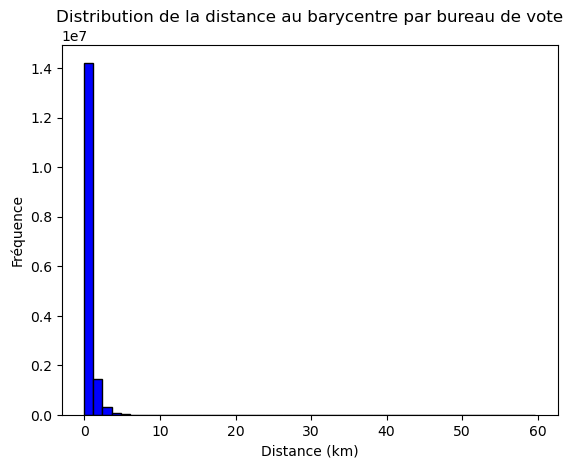

In [27]:
# Barycentres proches

distances = df_avec_barycentres["distance_barycentre"].values

# Trace un histogramme
plt.hist(distances, bins=50, color="blue", edgecolor="black")

# Ajoute un titre et des étiquettes d'axe
plt.title("Distribution de la distance au barycentre par bureau de vote")
plt.xlabel("Distance (km)")
plt.ylabel("Fréquence")

# Affiche le graphe
plt.show()

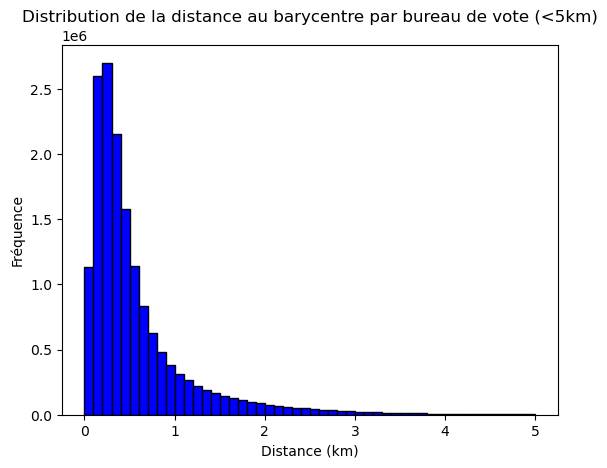

In [16]:
# Barycentres proches

distances_short = df_avec_barycentres[df_avec_barycentres['is_barycentre_close']]["distance_barycentre"].values

# Trace un histogramme
plt.hist(distances_short, bins=50, color="blue", edgecolor="black")

# Ajoute un titre et des étiquettes d'axe
plt.title("Distribution de la distance au barycentre par bureau de vote (<5km)")
plt.xlabel("Distance (km)")
plt.ylabel("Fréquence")

# Affiche le graphe
plt.show()

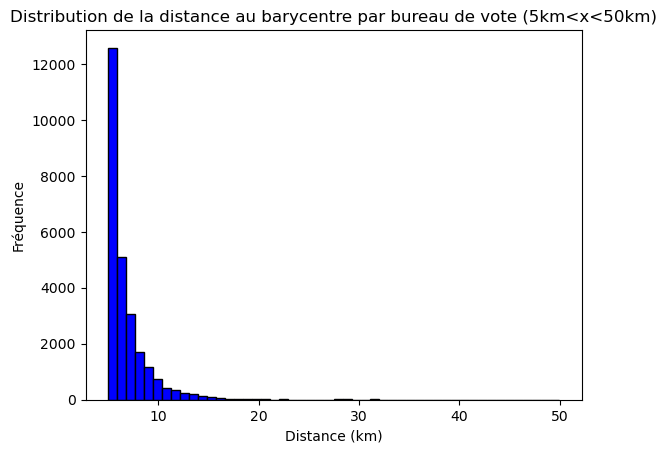

In [17]:
# Barycentres lointains

distances_long = df_avec_barycentres[df_avec_barycentres['is_barycentre_far']]["distance_barycentre"].values

# Trace un histogramme
plt.hist(distances_long, bins=50, color="blue", edgecolor="black")

# Ajoute un titre et des étiquettes d'axe
plt.title("Distribution de la distance au barycentre par bureau de vote (5km<x<50km)")
plt.xlabel("Distance (km)")
plt.ylabel("Fréquence")

# Affiche le graphe
plt.show()

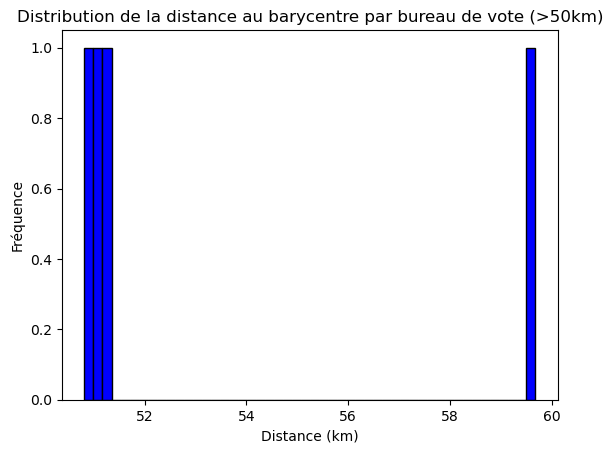

In [18]:
# Barycentres beaucoup trop lointains

distances_way_too_long = df_avec_barycentres[df_avec_barycentres['is_barycentre_way_too_far']]["distance_barycentre"].values

# Trace un histogramme
plt.hist(distances_way_too_long, bins=50, color="blue", edgecolor="black")

# Ajoute un titre et des étiquettes d'axe
plt.title("Distribution de la distance au barycentre par bureau de vote (>50km)")
plt.xlabel("Distance (km)")
plt.ylabel("Fréquence")

# Affiche le graphe
plt.show()

In [26]:
df_avec_barycentres[df_avec_barycentres['distance_barycentre'] > 20].sort_values("distance_barycentre", ascending=False)

,id_adresse,geo_adresse,code_commune_ref,reconstitution_code_commune,commune_identique,id,api_line,geo_type,geo_score,longitude,latitude,id_brut_bv,departement,latitude_barycentre,longitude_barycentre,distance_barycentre,is_barycentre_close,is_barycentre_far,is_barycentre_way_too_far
15838117,19026322,Jevrede Kampou 97317 Apatou,97360,1,1,97360_B086,BANG,street,0.95,-54.422042,4.621363,97360_1,97,5.154722,-54.339798,59.681389,False,False,True
15820894,19026669,Koffi Kampou 97317 Apatou,97360,1,1,97360_B008,BANG,street,0.48,-54.421713,4.621105,97360_3,97,5.078135,-54.349347,51.172843,False,False,True
15820872,19026616,Jevrede Kampou 97317 Apatou,97360,1,1,97360_B086,BANG,street,0.95,-54.422042,4.621363,97360_3,97,5.078135,-54.349347,51.150406,False,False,True
15820882,19026598,Améké Kampou 97317 Apatou,97360,1,1,97360_B029,BANG,street,0.81,-54.424902,4.624913,97360_3,97,5.078135,-54.349347,50.814143,False,False,True
15820891,19026612,Fedi Kampou 97317 Apatou,97360,1,1,97360_B032,BANG,street,0.68,-54.428171,4.633472,97360_3,97,5.078135,-54.349347,49.943076,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4159948,5164605,Les Glénan Ile du Loc H 29170 Fouesnant,29058,1,1,29058_B417,BANN,street,0.54,-3.997680,47.704748,29058_3,29,47.887408,-3.996237,20.309565,False,True,False
8023141,9749524,Les Landes (La Chaussaire) 49110 Montrevault-s...,49218,1,1,49085_B222,BANG,street,0.64,-1.173670,47.196103,49218_10,49,47.285182,-0.940865,20.218175,False,True,False
15820881,19026584,Rue Da Adjambi 97317 Apatou,97360,1,1,97360_cc9pr0,BANN,street,0.38,-54.281170,5.247602,97360_3,97,5.078135,-54.349347,20.207255,False,True,False
15832803,19012191,Route de l’Est 97311 Roura,97310,1,1,97310_0007,BANG,street,0.96,-52.427721,4.762227,97310_2,97,4.582177,-52.450056,20.063837,False,True,False


In [20]:
df_avec_barycentres[
    df_avec_barycentres['is_barycentre_way_too_far']][
        ['code_commune_ref']].sort_values(by='code_commune_ref')

,code_commune_ref
15820872,97360
15820882,97360
15820894,97360
15838117,97360


### Regarder les bureaux de vote

In [36]:
df_bv = pd.read_parquet('/home/onyxia/work/adresses-reu/table_correspondance_bv_simplifiee.parquet')
len(df_bv)

68867

In [22]:
df_bv.head()

,id_brut_reu,id_brut_insee,code_commune,code,libelle_reu,num_voie_reu,voie_reu,cp_reu,commune_reu,in_INSEE,nb_adresses
0,97209_48,97209_48,97209,48,ecole primaire de plateau didier simone vaton,0,ROUTE DESROCHERS,97200,fort de france,True,1805
1,31555_130,31555_130,31555,130,ecole fontaine bayonne,14,RUE DUFAUR DE PIBRAC,31300,toulouse,True,1775
2,97209_18,97209_18,97209,18,ecole primaire de dillon d louis moise,0,AVENUE PROFESSEUR JUDES TURIAF,97200,fort de france,True,1769
3,33063_4302,33063_4302,33063,4302,achard salle 2,,"6, rue Destanque",33300,bordeaux,True,1753
4,97209_24,97209_24,97209,24,ecole primaire de chateauboeuf theodore burnet,0,ROUTE DE CHATEAUBOEUF,97200,fort de france,True,1711


In [23]:
nb_bv_par_commune = df_bv.groupby('commune_reu').size().reset_index().rename({0:'nb_bv'}, axis=1)#.sort_values()
print(len(nb_bv_par_commune[nb_bv_par_commune['nb_bv'] == 1]))
print(len(nb_bv_par_commune))

23347
30567


In [24]:
nb_adresses_par_bv = df_avec_barycentres.groupby('id_brut_bv').size().reset_index(name='counts')
nb_adresses_par_bv

,id_brut_bv,counts
0,01001_1,306
1,01002_1,112
2,01004_1,405
3,01004_2,392
4,01004_3,509
...,...,...
68850,97801_5,1
68851,97801_6,1
68852,97801_7,1
68853,97801_8,1


In [28]:
nb_adresses_par_bv_avec_types = df_avec_barycentres.groupby(['id_brut_bv', 'geo_type']).size().reset_index(name='counts')
nb_adresses_par_bv_avec_types

,id_brut_bv,geo_type,counts
0,01001_1,housenumber,301
1,01001_1,street,5
2,01002_1,housenumber,108
3,01002_1,municipality,1
4,01002_1,street,3
...,...,...,...
191651,97801_5,municipality,1
191652,97801_6,municipality,1
191653,97801_7,municipality,1
191654,97801_8,municipality,1


In [30]:
bv_wider = pd.pivot(nb_adresses_par_bv_avec_types,
                    index = 'id_brut_bv',
                    columns = 'geo_type',
                    values = 'counts')
bv_wider.fillna(0, inplace=True)
bv_wider

geo_type,housenumber,interpolation,locality,municipality,street,village
id_brut_bv,,,,,,
01001_1,301.0,0.0,0.0,0.0,5.0,0.0
01002_1,108.0,0.0,0.0,1.0,3.0,0.0
01004_1,391.0,1.0,0.0,1.0,12.0,0.0
01004_2,384.0,2.0,0.0,0.0,6.0,0.0
01004_3,492.0,5.0,2.0,0.0,10.0,0.0
...,...,...,...,...,...,...
97801_5,0.0,0.0,0.0,1.0,0.0,0.0
97801_6,0.0,0.0,0.0,1.0,0.0,0.0
97801_7,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
communes_plumees = bv_wider[
    (bv_wider['housenumber'] == 0) & (bv_wider['interpolation'] == 0) & (bv_wider['street'] == 0) & (bv_wider['locality'] == 0)
    ]
communes_plumees

geo_type,housenumber,interpolation,locality,municipality,street,village
id_brut_bv,,,,,,
04107_1,0.0,0.0,0.0,1.0,0.0,0.0
15048_1,0.0,0.0,0.0,1.0,0.0,0.0
15217_1,0.0,0.0,0.0,1.0,0.0,0.0
15218_1,0.0,0.0,0.0,1.0,0.0,0.0
15247_1,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
97801_5,0.0,0.0,0.0,1.0,0.0,0.0
97801_6,0.0,0.0,0.0,1.0,0.0,0.0
97801_7,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
codes_plumes = list(communes_plumees.reset_index()['id_brut_bv'])
len([x for x in codes_plumes if x[:2] != '97'])

42

In [35]:
communes_plumees[communes_plumees['municipality'] == 0]

geo_type,housenumber,interpolation,locality,municipality,street,village
id_brut_bv,,,,,,


In [39]:
communes_plumees_bis = bv_wider[
    (bv_wider['housenumber'] + bv_wider['interpolation'] + bv_wider['street'] + bv_wider['locality'] == 1)
    ]
communes_plumees_bis

geo_type,housenumber,interpolation,locality,municipality,street,village
id_brut_bv,,,,,,
04009_1,0.0,0.0,0.0,1.0,1.0,0.0
04054_1,0.0,0.0,0.0,1.0,1.0,0.0
05066_1,0.0,0.0,1.0,1.0,0.0,0.0
06088_421,1.0,0.0,0.0,0.0,0.0,0.0
06119_1,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...
97228_11,0.0,0.0,0.0,0.0,1.0,0.0
97314_1,0.0,0.0,1.0,1.0,0.0,0.0
97352_1,0.0,0.0,0.0,1.0,1.0,0.0


In [44]:
codes_plumes_bis = list(communes_plumees_bis.reset_index()['id_brut_bv'])
len([x for x in codes_plumes_bis if x[:2] != '97'])

171